# <h1 style="font-family: Trebuchet MS; padding: 8 px; font-size: 38px; color: #4A1B8C; text-align: center; line-height: 1.2;"><b>Propensity model for bank </b> <br> Train models

## Load libraries and data

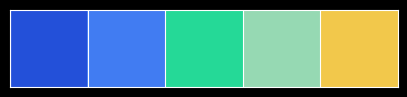

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import seaborn as sns
import pickle

#-----------------------------
from sklearn.model_selection import KFold, cross_validate, train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, confusion_matrix, precision_recall_curve, roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.svm import SVC

from catboost import CatBoostClassifier
#-----------------------------
import warnings
warnings.filterwarnings("ignore")

class clr:
    S = '\033[1m' + '\033[94m'
    E = '\033[0m'

my_colors = ['#2350D9', '#417CF2', '#25D997', '#96D9B3', '#F2C84B']
CMAP1 = ListedColormap(my_colors)
plt.style.use('dark_background')

sns.palplot(sns.color_palette(my_colors))

RANDOM_STATE=42

In [2]:
data = pd.read_csv('data/final.csv')
data.head()

,AGREEMENT_RK,age,gender,education,marital_status,child_total,dependants,socstatus_work_fl,socstatus_pens_fl,own_auto,fl_presence_fl,family_income,personal_income,credit,loan_num_total,loan_num_closed,target
0,60099204,42,1,Среднее,Не состоял в браке,1,0,1,0,0,1,от 20000 до 50000 руб.,25000,5588,1,0,1
1,62244665,28,1,Среднее специальное,Состою в браке,1,1,1,0,0,0,от 10000 до 20000 руб.,10000,19498,1,0,0
2,61050759,64,0,Среднее специальное,Состою в браке,2 и больше,0,1,1,1,0,от 20000 до 50000 руб.,30000,15470,1,1,0
3,62079659,54,1,Среднее специальное,Состою в браке,0,0,1,0,1,1,от 20000 до 50000 руб.,25000,13960,1,0,0
4,66583553,26,0,Среднее специальное,Состою в браке,1,1,1,0,0,1,от 10000 до 20000 руб.,15000,11890,2,2,0


In [3]:
data.columns = map(str.lower, data.columns)

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15006 entries, 0 to 15005
Data columns (total 17 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   agreement_rk       15006 non-null  int64 
 1   age                15006 non-null  int64 
 2   gender             15006 non-null  int64 
 3   education          15006 non-null  object
 4   marital_status     15006 non-null  object
 5   child_total        15006 non-null  object
 6   dependants         15006 non-null  object
 7   socstatus_work_fl  15006 non-null  int64 
 8   socstatus_pens_fl  15006 non-null  int64 
 9   own_auto           15006 non-null  int64 
 10  fl_presence_fl     15006 non-null  int64 
 11  family_income      15006 non-null  object
 12  personal_income    15006 non-null  int64 
 13  credit             15006 non-null  int64 
 14  loan_num_total     15006 non-null  int64 
 15  loan_num_closed    15006 non-null  int64 
 16  target             15006 non-null  int64

In [5]:
features_data = data.drop(['target', 'agreement_rk'], axis=1)
target_data = data['target']

## Data preprocessing

Split data to train and test samples

In [6]:
X_train, X_test, y_train, y_test = train_test_split(features_data, target_data, test_size=0.2, random_state=42)

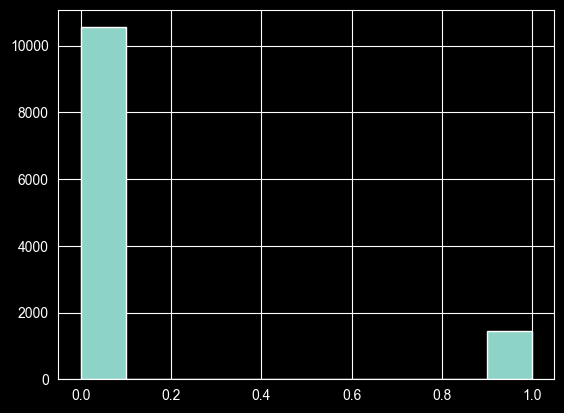

In [7]:
y_train.hist();

Scale numeric columns and coding categorical features

In [8]:
numeric = ['age', 'personal_income', 'credit', 'loan_num_total', 'loan_num_closed']
categorical = ['gender', 'education', 'marital_status',
       'child_total', 'dependants', 'socstatus_work_fl', 'socstatus_pens_fl',
       'own_auto', 'fl_presence_fl', 'family_income']

In [9]:
col_transformer = ColumnTransformer(
    transformers=[
        ('scaler', StandardScaler(), numeric),
        ('ohe', OneHotEncoder(sparse=False, drop='first'), categorical)],
    remainder="passthrough"
)

In [10]:
X_train = col_transformer.fit_transform(X_train)
X_test = col_transformer.transform(X_test)

In [11]:
print(clr.S + 'Train sample size ' + clr.E + f'{X_train.shape}')
print(clr.S + 'Test sample size ' + clr.E + f'{X_test.shape}')

Train sample size (12004, 24)
Test sample size (3002, 24)


## Logistic Regression

In [12]:
lr_model = LogisticRegression()
lr_model.fit(X_train, y_train)

LogisticRegression()

In [13]:
probs = lr_model.predict_proba(X_test)
pred_test = lr_model.predict(X_test)

In [14]:
print(clr.S + 'Accuracy ' + clr.E + f'{accuracy_score(y_test, pred_test)}')
print(clr.S + 'Recall ' + clr.E + f'{recall_score(y_test, pred_test)}')
print(clr.S + 'Precision ' + clr.E + f'{precision_score(y_test, pred_test)}')
print(clr.S + 'F1-score ' + clr.E + f'{f1_score(y_test, pred_test)}')

Accuracy 0.8867421718854097
Recall 0.0
Precision 0.0
F1-score 0.0


In [15]:
confusion_matrix(y_test, pred_test)

array([[2662,    2],
       [ 338,    0]])

Model can't correctly identify churn customers.
Since we have imbalanced data, let's try to move thresholds to optimize recall/presicion

### Optimal Threshold for Precision-Recall Curve

In [16]:
X_train_1, X_val, y_train_1, y_val = train_test_split(X_train, y_train, test_size=0.33, random_state=RANDOM_STATE)

In [17]:
print(clr.S + 'Train sample size ' + clr.E + f'{X_train_1.shape}')
print(clr.S + 'Validation sample size ' + clr.E + f'{X_val.shape}')

Train sample size (8042, 24)
Validation sample size (3962, 24)


Calculate the precision and recall for each threshold and create a precision-recall plot

The best threshold will be considered with recall > 0.66 and maximum precision

Best Threshold 0.11852713025686429
Best Recall 0.6616052060737527
Best Precision 0.16345123258306538


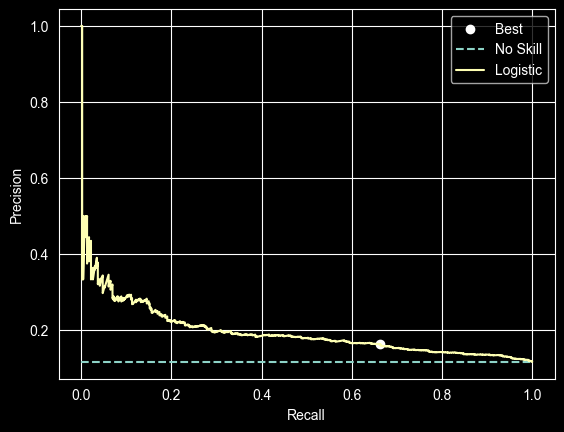

In [18]:
# predict probabilities
yhat = lr_model.predict_proba(X_val)
# keep probabilities for the positive outcome only
yhat = yhat[:, 1]
# calculate pr-curve
precision, recall, thresholds = precision_recall_curve(y_val, yhat)
# plot the roc curve for the model

no_skill = len(y_val[y_val==1]) / len(y_val)

indexes = [
    index for index in range(len(recall))
    if recall[index] > 0.66
]
ix = np.argmax(precision[indexes])
print(clr.S + 'Best Threshold ' + clr.E + f'{thresholds[ix]}')
print(clr.S + 'Best Recall ' + clr.E + f'{recall[ix]}')
print(clr.S + 'Best Precision ' + clr.E + f'{precision[ix]}')
plt.scatter(recall[ix], precision[ix], marker='o', color='white', label='Best')
plt.plot([0,1], [no_skill,no_skill], linestyle='--', label='No Skill')
plt.plot(recall, precision, label='Logistic')

# axis labels
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
# show the plot
plt.show()

With threshold 0.1 we get best Recall 0.97 with max precision 0.12

### Gridsearch


Hyperparameters tuning with GridSearchCV

In [19]:
grid={"C":np.logspace(-3,3,7), "penalty":["l1","l2", None], "solver":['lbfgs', 'liblinear']}
logreg=LogisticRegression(n_jobs=-1)
logreg_cv=GridSearchCV(logreg, grid, scoring='recall' ,cv=10)
logreg_cv.fit(X_train, y_train)


GridSearchCV(cv=10, estimator=LogisticRegression(n_jobs=-1),
             param_grid={'C': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03]),
                         'penalty': ['l1', 'l2', None],
                         'solver': ['lbfgs', 'liblinear']},
             scoring='recall')

In [20]:
logreg_cv_pred = logreg_cv.predict(X_val)
print(clr.S + 'Accuracy ' + clr.E + f'{accuracy_score(y_val, logreg_cv_pred)}')
print(clr.S + 'Recall ' + clr.E + f'{recall_score(y_val, logreg_cv_pred)}')
print(clr.S + 'Precision ' + clr.E + f'{precision_score(y_val, logreg_cv_pred)}')
print(clr.S + 'F1-score ' + clr.E + f'{f1_score(y_val, logreg_cv_pred)}')
print(clr.S + 'ROC-AUC-score ' + clr.E + f'{roc_auc_score(y_val, logreg_cv_pred)}')

Accuracy 0.8831398283695103
Recall 0.004338394793926247
Precision 0.3333333333333333
F1-score 0.008565310492505354
ROC-AUC-score 0.5015979320442067


In [21]:
logreg_cv.best_params_

{'C': 0.001, 'penalty': None, 'solver': 'lbfgs'}

With standart threshold tuned linear model shows quite low recall and precision;

Let's optimize threshold for best recall and precision

Best Threshold 0.11799236827343693
Best Recall 0.6637744034707158
Best Precision 0.1624203821656051


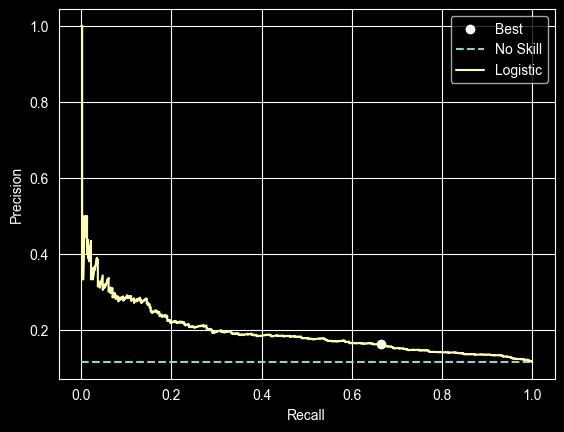

In [22]:
probs_churn = logreg_cv.predict_proba(X_val)[:, 1]
# calculate pr-curve
precision, recall, thresholds = precision_recall_curve(y_val, probs_churn)
# plot the roc curve for the model
no_skill = len(y_val[y_val==1]) / len(y_val)

indexes = [
    index for index in range(len(recall))
    if recall[index] > 0.66
]
ix = np.argmax(precision[indexes])
print(clr.S + 'Best Threshold ' + clr.E + f'{thresholds[ix]}')
print(clr.S + 'Best Recall ' + clr.E + f'{recall[ix]}')
print(clr.S + 'Best Precision ' + clr.E + f'{precision[ix]}')
plt.scatter(recall[ix], precision[ix], marker='o', color='white', label='Best')
plt.plot([0,1], [no_skill,no_skill], linestyle='--', label='No Skill')
plt.plot(recall, precision, label='Logistic')

# axis labels
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
# show the plot
plt.show()

In [23]:
test_pred = logreg_cv.predict_proba(X_val)
classes = test_pred[:,1] > 0.12
print(clr.S + 'Accuracy ' + clr.E + f'{accuracy_score(y_val, classes)}')
print(clr.S + 'Recall ' + clr.E + f'{recall_score(y_val, classes)}')
print(clr.S + 'Precision ' + clr.E + f'{precision_score(y_val, classes)}')
print(clr.S + 'F1-score ' + clr.E + f'{f1_score(y_val, classes)}')
print(clr.S + 'ROC-AUC-score ' + clr.E + f'{roc_auc_score(y_val, classes)}')


Accuracy 0.5774861181221606
Recall 0.6442516268980477
Precision 0.16436081903707803
F1-score 0.2619047619047619
ROC-AUC-score 0.6064731427834997


### Test model

In [24]:
test_pred = logreg_cv.predict_proba(X_test)
classes = test_pred[:,1] > 0.12
print(clr.S + 'Accuracy ' + clr.E + f'{accuracy_score(y_test, classes)}')
print(clr.S + 'Recall ' + clr.E + f'{recall_score(y_test, classes)}')
print(clr.S + 'Precision ' + clr.E + f'{precision_score(y_test, classes)}')
print(clr.S + 'F1-score ' + clr.E + f'{f1_score(y_test, classes)}')
print(clr.S + 'ROC-AUC-score ' + clr.E + f'{roc_auc_score(y_test, classes)}')

Accuracy 0.5606262491672218
Recall 0.6923076923076923
Precision 0.16149068322981366
F1-score 0.26189143816452154
ROC-AUC-score 0.6181133056133056


On the test sample we obtained a higher recall and lower precision

### Feature importance

<Axes: ylabel='Feature'>

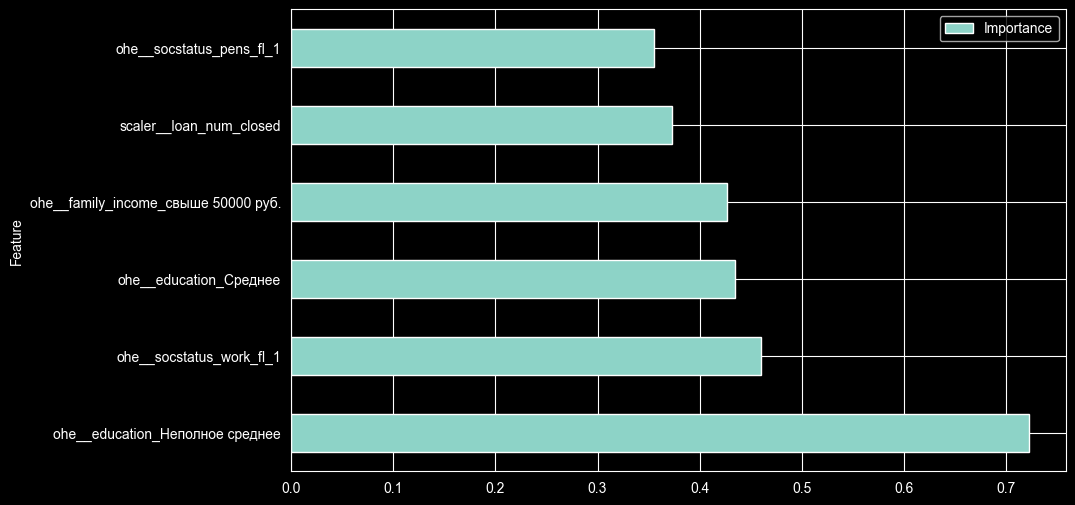

In [25]:
coefficients = logreg_cv.best_estimator_.coef_[0]

feature_importance = pd.DataFrame({'Feature': col_transformer.get_feature_names_out(), 'Importance': np.abs(coefficients)})
feature_importance = feature_importance.sort_values('Importance', ascending=False)
feature_importance[:6].plot(x='Feature', y='Importance', kind='barh', figsize=(10, 6))

In [26]:
feature_importance[:10]

,Feature,Importance
6,ohe__education_Неполное среднее,0.721888
17,ohe__socstatus_work_fl_1,0.459980
7,ohe__education_Среднее,0.434419
23,ohe__family_income_свыше 50000 руб.,0.427011
4,scaler__loan_num_closed,0.372374
18,ohe__socstatus_pens_fl_1,0.355347
0,scaler__age,0.275339
8,ohe__education_Среднее специальное,0.204642
1,scaler__personal_income,0.199276
3,scaler__loan_num_total,0.188969


Most important features are pension status, number of closed loans and age of client

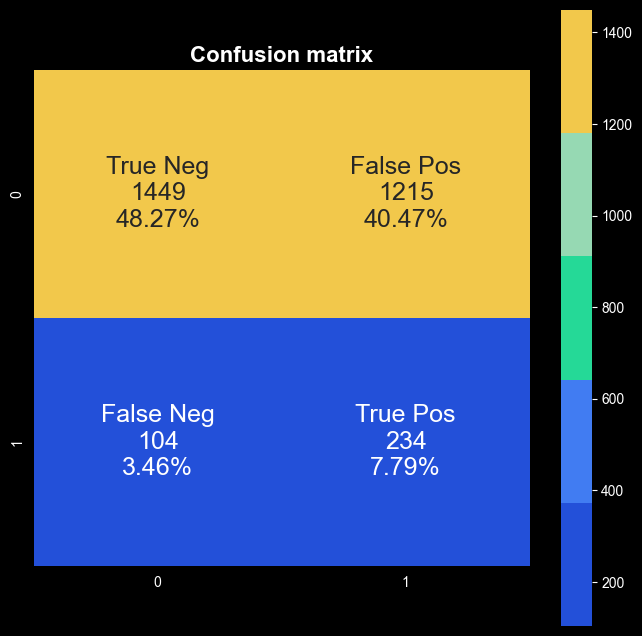

In [27]:
matrix = confusion_matrix(y_test, classes)
fig = plt.figure(figsize=(8, 8))

group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ['{0:0.0f}'.format(value) for value in matrix.flatten()]
group_percentages = ['{0:.2%}'.format(value) for value in matrix.flatten()/np.sum(matrix)]
labels = [f'{v1}\n{v2}\n{v3}'for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(matrix, annot=labels, fmt='', cmap=my_colors,  annot_kws={"size":18}, square=True)
plt.title('Confusion matrix', size=16, weight="bold" )
plt.show()

The model is good at recognizing clients who will not response to bank. There are almost no FalseNegative answers.

## Catboost classifier

### Gridsearch
Train another classification model with hyperparameter tuning

In [28]:
cb_model = CatBoostClassifier(loss_function='Logloss', eval_metric='Accuracy', iterations=500)

grid = {'learning_rate': [0.01, 0.03, 0.1],
        'depth': [4, 6, 10],
        'l2_leaf_reg': [1, 3, 5, 7, 9]}

cb_grid_search_result = cb_model.grid_search(grid,
                                       X=X_train,
                                       y=y_train,
                                       cv=3)

0:	learn: 0.8774341	test: 0.8846314	best: 0.8846314 (0)	total: 62.6ms	remaining: 31.2s
1:	learn: 0.8774341	test: 0.8846314	best: 0.8846314 (0)	total: 68.7ms	remaining: 17.1s
2:	learn: 0.8774341	test: 0.8846314	best: 0.8846314 (0)	total: 75.6ms	remaining: 12.5s
3:	learn: 0.8774341	test: 0.8846314	best: 0.8846314 (0)	total: 81ms	remaining: 10s
4:	learn: 0.8774341	test: 0.8846314	best: 0.8846314 (0)	total: 86.6ms	remaining: 8.58s
5:	learn: 0.8774341	test: 0.8846314	best: 0.8846314 (0)	total: 92.8ms	remaining: 7.64s
6:	learn: 0.8774341	test: 0.8846314	best: 0.8846314 (0)	total: 98.8ms	remaining: 6.96s
7:	learn: 0.8774341	test: 0.8846314	best: 0.8846314 (0)	total: 104ms	remaining: 6.42s
8:	learn: 0.8774341	test: 0.8846314	best: 0.8846314 (0)	total: 109ms	remaining: 5.95s
9:	learn: 0.8774341	test: 0.8846314	best: 0.8846314 (0)	total: 113ms	remaining: 5.53s
10:	learn: 0.8774341	test: 0.8846314	best: 0.8846314 (0)	total: 116ms	remaining: 5.17s
11:	learn: 0.8774341	test: 0.8846314	best: 0.88463

In [29]:
cb_grid_search_result['params']


{'depth': 4, 'l2_leaf_reg': 3, 'learning_rate': 0.1}

### Optimal threshold

Select the optimal threshold for CatBoost model

Best Threshold 0.14798059130950875
Best Recall 0.665943600867679
Best Precision 0.2957610789980732


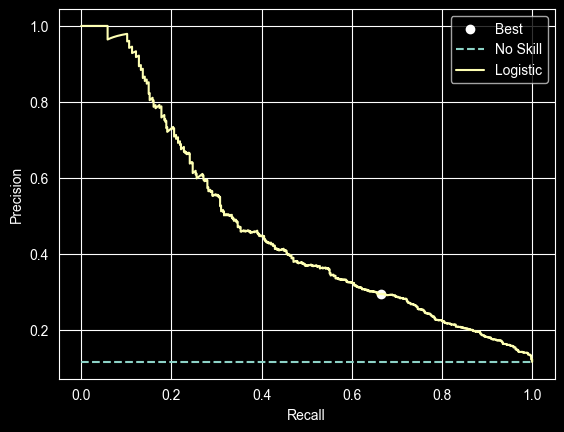

In [30]:
probs_churn = cb_model.predict_proba(X_val)[:, 1]
# calculate pr-curve
precision, recall, thresholds = precision_recall_curve(y_val, probs_churn)
# plot the roc curve for the model
no_skill = len(y_val[y_val==1]) / len(y_val)

indexes = [
    index for index in range(len(recall))
    if recall[index] > 0.66
]
ix = np.argmax(precision[indexes])
print(clr.S + 'Best Threshold ' + clr.E + f'{thresholds[ix]}')
print(clr.S + 'Best Recall ' + clr.E + f'{recall[ix]}')
print(clr.S + 'Best Precision ' + clr.E + f'{precision[ix]}')
plt.scatter(recall[ix], precision[ix], marker='o', color='white', label='Best')
plt.plot([0,1], [no_skill,no_skill], linestyle='--', label='No Skill')
plt.plot(recall, precision, label='Logistic')

# axis labels
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
# show the plot
plt.show()

In [31]:
classes = probs_churn > 0.15
print(clr.S + 'Accuracy ' + clr.E + f'{accuracy_score(y_val, classes)}')
print(clr.S + 'Recall ' + clr.E + f'{recall_score(y_val, classes)}')
print(clr.S + 'Precision ' + clr.E + f'{precision_score(y_val, classes)}')
print(clr.S + 'F1-score ' + clr.E + f'{f1_score(y_val, classes)}')
print(clr.S + 'ROC-AUC-score ' + clr.E + f'{roc_auc_score(y_val, classes)}')

Accuracy 0.782180716809692
Recall 0.6529284164859002
Precision 0.299800796812749
F1-score 0.41092150170648467
ROC-AUC-score 0.7260643224960206


CatboostClassifier shows better results then linear regression on validation sample

### Test model

In [32]:
test_pred = cb_model.predict_proba(X_test)
classes = test_pred[:,1] > 0.15
print(clr.S + 'Accuracy ' + clr.E + f'{accuracy_score(y_test, classes)}')
print(clr.S + 'Recall ' + clr.E + f'{recall_score(y_test, classes)}')
print(clr.S + 'Precision ' + clr.E + f'{precision_score(y_test, classes)}')
print(clr.S + 'F1-score ' + clr.E + f'{f1_score(y_test, classes)}')
print(clr.S + 'ROC-AUC-score ' + clr.E + f'{roc_auc_score(y_test, classes)}')

Accuracy 0.7085276482345103
Recall 0.3994082840236686
Precision 0.16728624535315986
F1-score 0.23580786026200873
ROC-AUC-score 0.5735780158857082


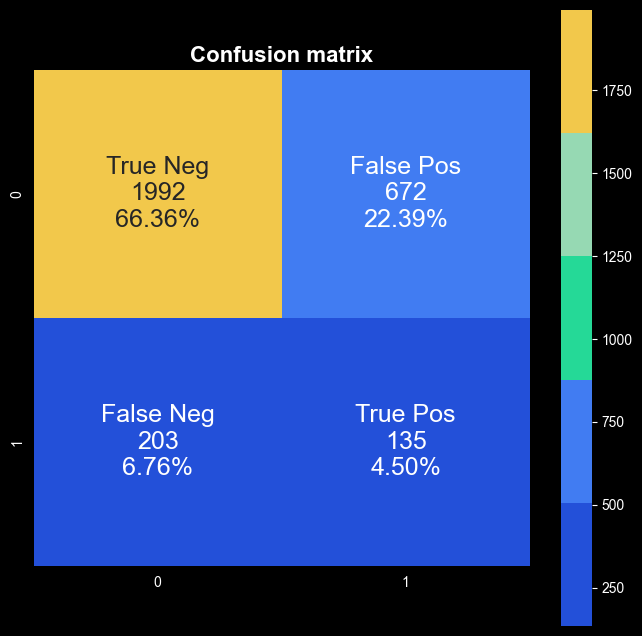

In [33]:
catboost_matrix = confusion_matrix(y_test, classes)
fig = plt.figure(figsize=(8, 8))

group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ['{0:0.0f}'.format(value) for value in catboost_matrix.flatten()]
group_percentages = ['{0:.2%}'.format(value) for value in catboost_matrix.flatten()/np.sum(catboost_matrix)]
labels = [f'{v1}\n{v2}\n{v3}'for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(catboost_matrix, annot=labels, fmt='', cmap=my_colors,  annot_kws={"size":18}, square=True)
plt.title('Confusion matrix', size=16, weight="bold" )
plt.show()

Catboost shows more True negative and less False positive results

### Feature importance

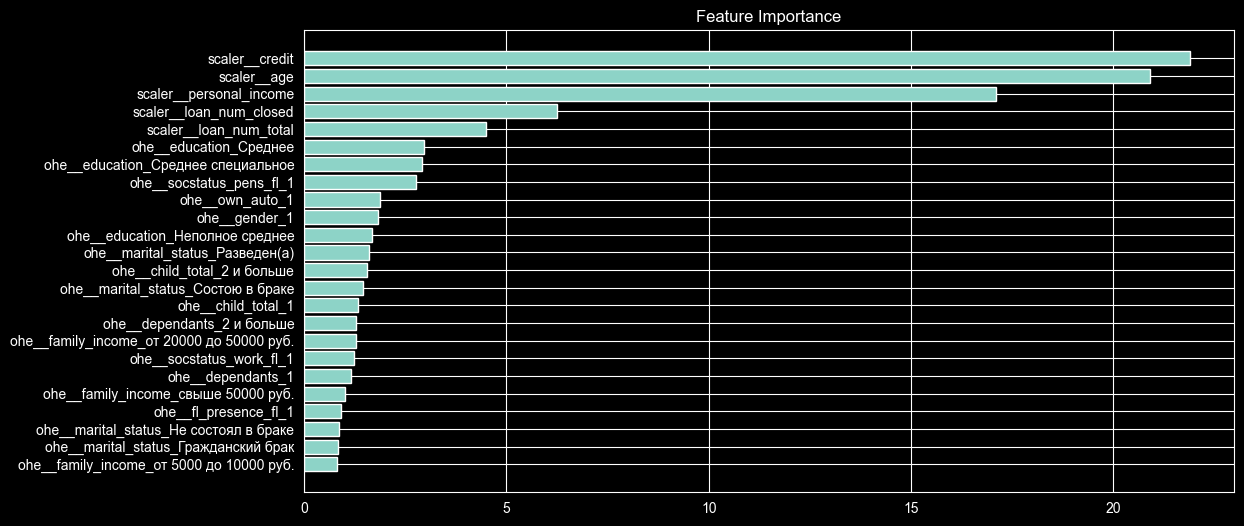

In [34]:
feature_importance = cb_model.feature_importances_
sorted_idx = np.argsort(feature_importance)
fig = plt.figure(figsize=(12, 6))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), col_transformer.get_feature_names_out()[sorted_idx])
plt.title('Feature Importance');

In [35]:
feature_importance_cb = pd.DataFrame({'Feature': col_transformer.get_feature_names_out(), 'Importance': feature_importance})
feature_importance_cb.sort_values('Importance', ascending=False)[:10]

,Feature,Importance
2,scaler__credit,21.890089
0,scaler__age,20.899689
1,scaler__personal_income,17.101148
4,scaler__loan_num_closed,6.248258
3,scaler__loan_num_total,4.502291
7,ohe__education_Среднее,2.973973
8,ohe__education_Среднее специальное,2.914866
18,ohe__socstatus_pens_fl_1,2.756925
19,ohe__own_auto_1,1.870879
5,ohe__gender_1,1.837600


## Support vector machine

In [36]:
svc_model = SVC(probability=True)

In [37]:
svc_model.fit(X_train, y_train)

SVC(probability=True)

In [38]:
probs = svc_model.predict_proba(X_val)
pred_test = svc_model.predict(X_val)
print(clr.S + 'Accuracy ' + clr.E + f'{accuracy_score(y_val, pred_test)}')
print(clr.S + 'Recall ' + clr.E + f'{recall_score(y_val, pred_test)}')
print(clr.S + 'Precision ' + clr.E + f'{precision_score(y_val, pred_test)}')
print(clr.S + 'F1-score ' + clr.E + f'{f1_score(y_val, pred_test)}')
print(clr.S + 'ROC-AUC-score ' + clr.E + f'{roc_auc_score(y_val, pred_test)}')

Accuracy 0.8836446239273095
Recall 0.0
Precision 0.0
F1-score 0.0
ROC-AUC-score 0.5


### Gridsearch

In [39]:
svc_model = SVC(probability=True, gamma='scale')

svc_grid = {'kernel': ('linear', 'rbf', 'sigmoid'),
           'C': [0.1, 1, 10]}

grid_cvc = GridSearchCV(svc_model, svc_grid, refit = True, verbose=2, cv=3)
grid_cvc.fit(X_train, y_train)

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV] END ...............................C=0.1, kernel=linear; total time=   1.3s
[CV] END ...............................C=0.1, kernel=linear; total time=   1.4s
[CV] END ...............................C=0.1, kernel=linear; total time=   1.3s
[CV] END ..................................C=0.1, kernel=rbf; total time=   4.4s
[CV] END ..................................C=0.1, kernel=rbf; total time=   4.4s
[CV] END ..................................C=0.1, kernel=rbf; total time=   4.5s
[CV] END ..............................C=0.1, kernel=sigmoid; total time=   2.5s
[CV] END ..............................C=0.1, kernel=sigmoid; total time=   2.5s
[CV] END ..............................C=0.1, kernel=sigmoid; total time=   2.6s
[CV] END .................................C=1, kernel=linear; total time=   1.5s
[CV] END .................................C=1, kernel=linear; total time=   1.5s
[CV] END .................................C=1, ke

GridSearchCV(cv=3, estimator=SVC(probability=True),
             param_grid={'C': [0.1, 1, 10],
                         'kernel': ('linear', 'rbf', 'sigmoid')},
             verbose=2)

In [40]:
grid_cvc.best_params_

{'C': 0.1, 'kernel': 'linear'}

### Optimal threshold

Best Threshold 0.12248089527052504
Best Recall 0.6616052060737527
Best Precision 0.12681912681912683


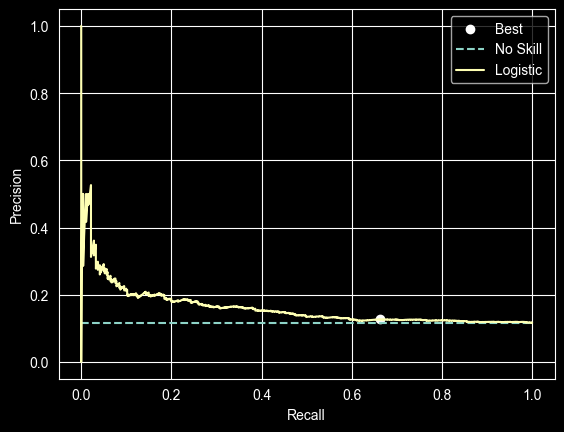

In [41]:
probs_churn = grid_cvc.predict_proba(X_val)[:, 1]
# calculate pr-curve
precision, recall, thresholds = precision_recall_curve(y_val, probs_churn)
# plot the roc curve for the model
no_skill = len(y_val[y_val==1]) / len(y_val)

indexes = [
    index for index in range(len(recall))
    if recall[index] > 0.66
]
ix = np.argmax(precision[indexes])
print(clr.S + 'Best Threshold ' + clr.E + f'{thresholds[ix]}')
print(clr.S + 'Best Recall ' + clr.E + f'{recall[ix]}')
print(clr.S + 'Best Precision ' + clr.E + f'{precision[ix]}')
plt.scatter(recall[ix], precision[ix], marker='o', color='white', label='Best')
plt.plot([0,1], [no_skill,no_skill], linestyle='--', label='No Skill')
plt.plot(recall, precision, label='Logistic')

# axis labels
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
# show the plot
plt.show()

In [43]:
classes = probs_churn > 0.12
print(clr.S + 'Accuracy ' + clr.E + f'{accuracy_score(y_val, classes)}')
print(clr.S + 'Recall ' + clr.E + f'{recall_score(y_val, classes)}')
print(clr.S + 'Precision ' + clr.E + f'{precision_score(y_val, classes)}')
print(clr.S + 'F1-score ' + clr.E + f'{f1_score(y_val, classes)}')
print(clr.S + 'ROC-AUC-score ' + clr.E + f'{roc_auc_score(y_val, classes)}')

Accuracy 0.22690560323069156
Recall 0.8828633405639913
Precision 0.11914519906323184
F1-score 0.20995615166365744
ROC-AUC-score 0.5116973086710274


### Test model

In [50]:
test_pred = grid_cvc.predict_proba(X_test)
classes = test_pred[:, 1] > 0.15
print(clr.S + 'Accuracy ' + clr.E + f'{accuracy_score(y_test, classes)}')
print(clr.S + 'Recall ' + clr.E + f'{recall_score(y_test, classes)}')
print(clr.S + 'Precision ' + clr.E + f'{precision_score(y_test, classes)}')
print(clr.S + 'F1-score ' + clr.E + f'{f1_score(y_test, classes)}')
print(clr.S + 'ROC-AUC-score ' + clr.E + f'{roc_auc_score(y_test, classes)}')

Accuracy 0.8870752831445703
Recall 0.0
Precision 0.0
F1-score 0.0
ROC-AUC-score 0.4998123123123123


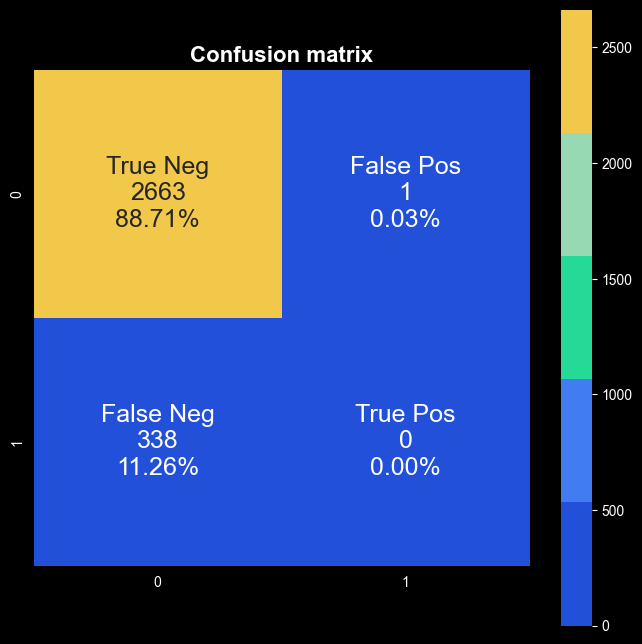

In [51]:
catboost_matrix = confusion_matrix(y_test, classes)
fig = plt.figure(figsize=(8, 8))
group_names = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
group_counts = ['{0:0.0f}'.format(value) for value in catboost_matrix.flatten()]
group_percentages = ['{0:.2%}'.format(value) for value in catboost_matrix.flatten() / np.sum(catboost_matrix)]
labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in zip(group_names, group_counts, group_percentages)]
labels = np.asarray(labels).reshape(2, 2)
sns.heatmap(catboost_matrix, annot=labels, fmt='', cmap=my_colors, annot_kws={"size": 18}, square=True)
plt.title('Confusion matrix', size=16, weight="bold")
plt.show()

### Feature importance


<Axes: ylabel='Feature'>

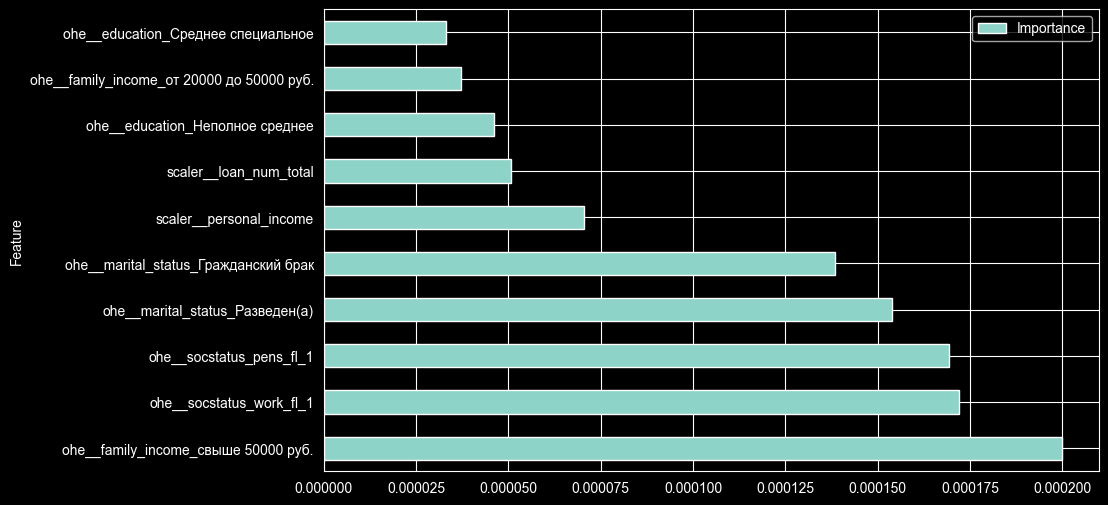

In [45]:
coefficients = grid_cvc.best_estimator_.coef_[0]

feature_importance = pd.DataFrame({'Feature': col_transformer.get_feature_names_out(), 'Importance': np.abs(coefficients)})
feature_importance = feature_importance.sort_values('Importance', ascending=False)
feature_importance[:10].plot(x='Feature', y='Importance', kind='barh', figsize=(10, 6))

In [48]:
feature_importance[:10]

,Feature,Importance
23,ohe__family_income_свыше 50000 руб.,0.000200
17,ohe__socstatus_work_fl_1,0.000172
18,ohe__socstatus_pens_fl_1,0.000169
11,ohe__marital_status_Разведен(а),0.000154
9,ohe__marital_status_Гражданский брак,0.000138
1,scaler__personal_income,0.000071
3,scaler__loan_num_total,0.000051
6,ohe__education_Неполное среднее,0.000046
21,ohe__family_income_от 20000 до 50000 руб.,0.000037
8,ohe__education_Среднее специальное,0.000033


## Conclusions

- Three classification models LogisticRegression, CatBoost and Support Vector Classification were tested.
- The GridSearchCV method was used to fit hyperparameters for all models.
- The models were optimised by the likelihood threshold for wrestling

**Table with results**

| Model              |                   Hyperparameters                    | Threshold | Roc-Auc | Recall | Presicion | 
|--------------------|:----------------------------------------------------:|----------:|--------:|-------:|----------:|
| LogisticRegression |   {'C': 0.001, 'penalty': None, 'solver': 'lbfgs'}   |      0.12 |    0.61 |   0.64 |      0.16 |
| CatBoost           | {'depth': 4, 'l2_leaf_reg': 3, 'learning_rate': 0.1} |      0.15 |    0.73 |   0.65 |      0.30 |
| SVC                |            {'C': 0.1, 'kernel': 'linear'}            |      0.12 |    0.51 |   0.88 |      0.12 |


Catboost classifier showed the best results on the validation sample. The most important features are age, credit and personal income.